```
SOW-MKI95 Computer Graphics & Computer Vision Spring 2020
Dr. Umut Güçlü
Lab 14: Generative adversarial networks
12-06-2020
```

```
Group number: 8
Chris Beem: s1044334
Nolan Cardozo: s1034065
Ajinkya Indulkar: s1034517
```

In this lab, you will reimplement the DCGAN from the Gluon tutorial, convert it to a WGAN and compare their results after training them on different datasets.

In [1]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d vishalsubbiah/pokemon-images-and-types
!kaggle datasets download -d soumikrakshit/anime-faces
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

!unzip -q pokemon-images-and-types.zip -d pokemon-dataset
!unzip -q anime-faces.zip -d anime-dataset
!unzip -q stanford-dogs-dataset.zip -d dogs-dataset
!rm pokemon-images-and-types.zip
!rm anime-faces.zip
!rm stanford-dogs-dataset.zip

Saving kaggle.json to kaggle.json
kaggle.json
  0% 0.00/2.47M [00:00<?, ?B/s]
100% 2.47M/2.47M [00:00<00:00, 82.1MB/s]
 99% 437M/441M [00:05<00:00, 108MB/s] 
100% 441M/441M [00:05<00:00, 80.9MB/s]
 98% 734M/750M [00:07<00:00, 122MB/s]
100% 750M/750M [00:07<00:00, 99.3MB/s]


In [2]:
!pip install mxnet-cu100 

     |████████████████████████████████| 540.1MB 33kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [3]:
import os
import time
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

import numpy as np
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
from mxnet.optimizer import RMSProp

### Task 1 (33 points):

Reimplement the DCGAN from the Gluon tutorial in this notebook. You can find the Gluon tutorial [here](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html).

In [4]:
# define parameters
batch_size = 32
latent_z_size = 100
lr = 0.0002
beta1 = 0.5

#### Load and Preprocess LWF Face Dataset

In [5]:
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

In [6]:
def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3)
    # to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

In [7]:
target_wd = 64
target_ht = 64
img_list = []

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

Visualize Images

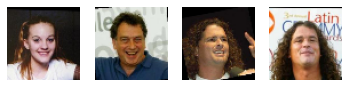

In [8]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

#### Define Model

In [15]:
# set training parameters
epochs = 2

# set framework device
use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

In [16]:
def define_gan(nc=3, ngf=64):
    '''function to define DCGAN'''
    # build the generator
    netG = nn.Sequential()
    with netG.name_scope():
        # input is Z, going into a convolution
        netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
        netG.add(nn.BatchNorm())
        netG.add(nn.Activation('relu'))
        # state size. (ngf*8) x 4 x 4
        netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
        netG.add(nn.BatchNorm())
        netG.add(nn.Activation('relu'))
        # state size. (ngf*8) x 8 x 8
        netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
        netG.add(nn.BatchNorm())
        netG.add(nn.Activation('relu'))
        # state size. (ngf*8) x 16 x 16
        netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
        netG.add(nn.BatchNorm())
        netG.add(nn.Activation('relu'))
        # state size. (ngf*8) x 32 x 32
        netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
        netG.add(nn.Activation('tanh'))
        # state size. (nc) x 64 x 64

    # build the discriminator
    ndf = 64
    netD = nn.Sequential()
    with netD.name_scope():
        # input is (nc) x 64 x 64
        netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
        netD.add(nn.LeakyReLU(0.2))
        # state size. (ndf) x 32 x 32
        netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
        netD.add(nn.BatchNorm())
        netD.add(nn.LeakyReLU(0.2))
        # state size. (ndf) x 16 x 16
        netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
        netD.add(nn.BatchNorm())
        netD.add(nn.LeakyReLU(0.2))
        # state size. (ndf) x 8 x 8
        netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
        netD.add(nn.BatchNorm())
        netD.add(nn.LeakyReLU(0.2))
        # state size. (ndf) x 4 x 4
        netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))
    return netG, netD

#### Train Model

In [17]:
def train_dcgan(netG, netD, train_data, epochs, reset=True):
    '''function to train DCGAN'''
    # define loss
    loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

    # initialize the generator and the discriminator
    netG.initialize(mx.init.Normal(0.02), ctx=ctx)
    netD.initialize(mx.init.Normal(0.02), ctx=ctx)

    # define trainer (optimizer) for the generator and the discriminator
    trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
    trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
    
    # define labels
    real_label = nd.ones((batch_size,), ctx=ctx)
    fake_label = nd.zeros((batch_size,), ctx=ctx)

    def facc(label, pred):
        pred = pred.ravel()
        label = label.ravel()
        return ((pred > 0.5) == label).mean()
    metric = mx.metric.CustomMetric(facc)

    stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
    
    for epoch in range(epochs):
        tic = time.time()
        btic = time.time()
        if reset:
            train_data.reset()
        iter = 0
        for batch in train_data:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            data = batch.data[0].as_in_context(ctx)
            latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

            with autograd.record():
                # train with real image
                output = netD(data).reshape((-1, 1))
                errD_real = loss(output, real_label)
                metric.update([real_label,], [output,])

                # train with fake image
                fake = netG(latent_z)
                output = netD(fake.detach()).reshape((-1, 1))
                errD_fake = loss(output, fake_label)
                errD = errD_real + errD_fake
                errD.backward()
                metric.update([fake_label,], [output,])

            trainerD.step(batch.data[0].shape[0])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            with autograd.record():
                fake = netG(latent_z)
                output = netD(fake).reshape((-1, 1))
                errG = loss(output, real_label)
                errG.backward()

            trainerG.step(batch.data[0].shape[0])

            # Print log infomation every ten batches
            if iter % 50 == 0:
                name, acc = metric.get()
                print('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
                print('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                         %(nd.mean(errD).asscalar(),
                           nd.mean(errG).asscalar(), acc, iter, epoch))
            iter = iter + 1
            btic = time.time()

        name, acc = metric.get()
        metric.reset()
    return netG, netD

In [18]:
def plot_images(netG):
    '''function to generate images'''
    num_image = 8
    plt.figure()
    for i in range(num_image):
        latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
        img = netG(latent_z)
        plt.subplot(2,4,i+1)
        visualize(img[0])
    plt.show()
    
    num_image = 12
    plt.figure()
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    step = 0.05
    for i in range(num_image):
        img = netG(latent_z)
        plt.subplot(3,4,i+1)
        visualize(img[0])
        latent_z += 0.05
    plt.show()

#### Run Model

In [19]:
netG_dcgan, netD_dcgan = define_gan()

In [20]:
netG_dcgan, netD_dcgan = train_dcgan(netG_dcgan, netD_dcgan, train_data, epochs)

speed: 88.08278425587098 samples/s
discriminator loss = 1.914271, generator loss = 5.816593, binary training acc = 0.421875 at iter 0 epoch 0
speed: 288.18042607280427 samples/s
discriminator loss = 0.701833, generator loss = 23.427401, binary training acc = 0.933517 at iter 50 epoch 0
speed: 275.2958280346228 samples/s
discriminator loss = 0.913593, generator loss = 9.238294, binary training acc = 0.903465 at iter 100 epoch 0
speed: 283.0045291612196 samples/s
discriminator loss = 1.387450, generator loss = 9.189184, binary training acc = 0.866825 at iter 150 epoch 0
speed: 295.7640546496254 samples/s
discriminator loss = 0.429735, generator loss = 5.789958, binary training acc = 0.863495 at iter 200 epoch 0
speed: 297.5151852352653 samples/s
discriminator loss = 0.847560, generator loss = 3.419492, binary training acc = 0.868464 at iter 250 epoch 0
speed: 292.01191390484973 samples/s
discriminator loss = 0.428484, generator loss = 6.529183, binary training acc = 0.869705 at iter 300 

#### Plot Results

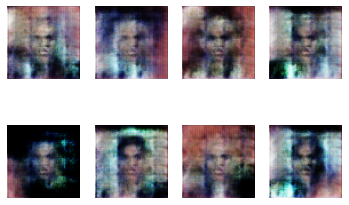

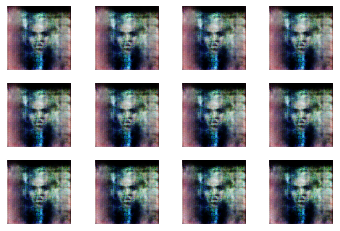

In [21]:
plot_images(netG_dcgan)

### Task 2 (33 points):

Convert the DCGAN to a WGAN.

You can refer to [the WGAN paper](https://arxiv.org/abs/1701.07875) and/or the below notes.

The paper introduces a new loss function for both the discriminator and the generator. Using this loss function instead of binary cross entropy results in a more stable convergence of the GAN.

#### Loss

Let’s compare the binary cross-entropy loss function (the function that that we are currently using to train the discriminator and generator of the DCGAN) to the Wasserstein loss function.

First, the Wasserstein loss requires that we use yi=1 and yi=-1 as labels, rather than 1 and 0. We also remove the sigmoid activation from the final layer of the discriminator, so that predictions pi are no longer constrained to fall in the range [0,1], but instead can now be any number in the range [–∞, ∞]. For this reason, the discriminator in a WGAN is usually referred to as a critic. The Wasserstein loss function is then defined as follows:

$$-\frac{1}{n} \sum_{i=1}^{n}\left(y_{i} p_{i}\right)$$

To train the WGAN critic D, we calculate the loss when comparing predictions for a real images pi=D(xi) to the response yi=1 and predictions for generated images pi=D(G(zi)) to the response yi=-1. Therefore for the WGAN critic, minimizing the loss function can be written as follows:

$$\min _{D}-\left(\mathbb{E}_{x \sim p_{X}}[D(x)]-\mathbb{E}_{z \sim p_{Z}}[D(G(z))]\right)$$

In other words, the WGAN critic tries to maximise the difference between its predictions for real images and generated images, with real images scoring higher. To train the WGAN generator, we calculate the loss when comparing predictions for generated images pi=D(G(zi)) to the response yi=1. Therefore for the WGAN generator, minimizing the loss function can be written as follows:

$$\min _{G}-\left(\mathbb{E}_{z \sim p_{Z}}[D(G(z))]\right)$$

#### Constraints

For the Wasserstein loss function to work, we also need to place an additional constraint on the critic. Specifically, it is required that the critic is a 1-Lipschitz continuous function. Let’s pick this apart to understand what it means in more detail. The critic is a function D that converts an image into a prediction. We say that this function is 1-Lipschitz if it satisfies the following inequality for any two input images, \( x_1 \) and \( x_2 \):

$$ \vert\frac{D(x_1)-D(x_2)\vert}{\vert x_1-x_2\vert}\leq1 $$

Essentially, we require a limit on the rate at which the predictions of the critic can change between two images (i.e., the absolute value of the gradient must be at most 1 everywhere).

It is possible to enforce the Lipschitz constraint by clipping the weights of the critic to lie within a small range, [–0.01, 0.01], after each training batch.

#### Training

When using the Wasserstein loss function, we should train the critic to convergence to ensure that the gradients for the generator update are accurate. This is in contrast to a standard GAN, where it is important not to let the discriminator get too strong, to avoid vanishing gradients.

Therefore, using the Wasserstein loss removes one of the key difficulties of training GANs—how to balance the training of the discriminator and generator. With WGANs, we can simply train the critic several times between generator updates, to ensure it is close to convergence. A typical ratio used is five critic updates to one generator update.

In [22]:
def train_wgan(netG, netD, train_data, epochs, reset=True):
    '''function to train WGAN'''
    # define loss
    def wasserstein_loss(y_true, y_pred):
        m_yt = nd.mean(y_true)
        m_yp = nd.mean(y_pred)
        return m_yt*m_yp

    # initialize the generator and the discriminator
    netG.initialize(mx.init.Normal(0.02), ctx=ctx)
    netD.initialize(mx.init.Normal(0.02), ctx=ctx)

    # define trainer (optimizer) for the generator and the discriminator
    trainerG = gluon.Trainer(netG.collect_params(),optimizer=RMSProp(learning_rate=0.0005))
    # implementing clip weights
    trainerD = gluon.Trainer(netD.collect_params(),optimizer=RMSProp(learning_rate=0.0005,
                                                                     clip_weights = 0.01))
    
    # define labels
    real_label = 1000.1*nd.ones((batch_size,), ctx=ctx)
    fake_label = -1000.1 * nd.ones((batch_size,), ctx=ctx)
    
    def facc(label, pred):
        pred = pred.ravel()
        label = label.ravel()
        return ((pred > 0.5) == label).mean()
        
    # define metric
    metric = mx.metric.CustomMetric(facc)

    stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')

    # train
    for epoch in range(epochs):
        tic = time.time()
        btic = time.time()
        train_data.reset()
        iter = 0
        for batch in train_data:
            ############################
            # (1) Update D network:
            ###########################
            for iteration in range(5):
                data = batch.data[0].as_in_context(ctx)
                latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)
                with autograd.record():
                    # train with real image
                    output = netD(data) 
                    errD_real = wasserstein_loss(output, real_label)
                    metric.update([real_label,], [output,])

                    # train with fake image
                    fake = netG(latent_z)
                    output = netD(fake.detach())
                    errD_fake = wasserstein_loss(output, fake_label)
                    errD = -1*(errD_real - errD_fake)
                    errD.backward()
                    metric.update([fake_label,], [output,])
                trainerD.step(batch.data[0].shape[0])

            ############################
            # (2) Update G network: 
            ###########################
            with autograd.record():
                fake = netG(latent_z)
                output = netD(fake)
                errG = (wasserstein_loss(output, real_label))
                errG.backward()

            trainerG.step(batch.data[0].shape[0])

            # Print log infomation every ten batches
            if iter % 50 == 0:
                name, acc = metric.get()
                print('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
                print('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                         %(nd.mean(errD).asscalar(),
                           nd.mean(errG).asscalar(), acc, iter, epoch))
            iter = iter + 1
            btic = time.time()

        name, acc = metric.get()
        metric.reset()
    return netG, netD

#### Run Model

In [23]:
netG_wgan, netD_wgan = define_gan()

In [24]:
netG_wgan, netD_wgan = train_wgan(netG_wgan, netD_wgan, train_data, epochs)

speed: 58.73072108036251 samples/s
discriminator loss = -336.536163, generator loss = 188.209320, binary training acc = 0.000000 at iter 0 epoch 0
speed: 93.65055513070271 samples/s
discriminator loss = -1917.950684, generator loss = 958.106812, binary training acc = 0.000000 at iter 50 epoch 0
speed: 93.0341900544199 samples/s
discriminator loss = -1921.630981, generator loss = 959.594360, binary training acc = 0.000000 at iter 100 epoch 0
speed: 92.56816379228296 samples/s
discriminator loss = -1922.279785, generator loss = 959.946411, binary training acc = 0.000000 at iter 150 epoch 0
speed: 93.83932383085144 samples/s
discriminator loss = -1922.770386, generator loss = 960.111511, binary training acc = 0.000000 at iter 200 epoch 0
speed: 94.41009083836623 samples/s
discriminator loss = -1922.110352, generator loss = 959.917908, binary training acc = 0.000000 at iter 250 epoch 0
speed: 93.72497657185075 samples/s
discriminator loss = -1922.988037, generator loss = 960.363159, binary

#### Plot Results

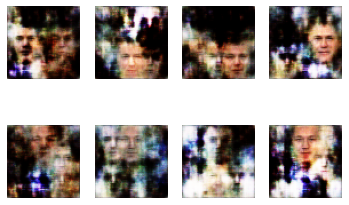

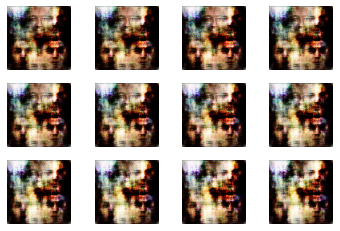

In [25]:
plot_images(netG_wgan)

In [26]:
# clear memory
del train_data, netG_dcgan, netG_wgan, netD_dcgan, netD_wgan

### Task 3 (33 points):

Compare their results of the DCGAN and the WGAN after training them on different datasets (at least three). You are free to select which datasets to use (it would be easier if you use relatively small datasets). For example, you can use MNIST and Fashion-MNIST datasets (available from Gluon) or anime characters and pokemons datasets (several versions can be found on GitHub).

### Train DCGAN and WGAN on Pokemon Dataset

In [55]:
img_list = []
data_path = 'pokemon-dataset'

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
pokemon_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

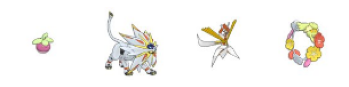

In [56]:
for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

In [57]:
# define GANs
netG_dcgan, netD_dcgan = define_gan()
netG_wgan, netD_wgan = define_gan()

In [58]:
# train DCGAN
netG_dcgan, netD_dcgan = train_dcgan(netG_dcgan, netD_dcgan, pokemon_data, epochs)

speed: 90.8010940695504 samples/s
discriminator loss = 1.284684, generator loss = 4.441106, binary training acc = 0.546875 at iter 0 epoch 0
speed: 262.2285072337765 samples/s
discriminator loss = 0.114718, generator loss = 6.658566, binary training acc = 1.000000 at iter 0 epoch 1


In [59]:
# train WGAN
netG_wgan, netD_wgan = train_wgan(netG_wgan, netD_wgan, pokemon_data, epochs)

speed: 55.73543533093423 samples/s
discriminator loss = -343.456055, generator loss = 178.106552, binary training acc = 0.000000 at iter 0 epoch 0
speed: 92.08953048776304 samples/s
discriminator loss = -902.274475, generator loss = 448.098450, binary training acc = 0.000000 at iter 0 epoch 1


#### Plot Results

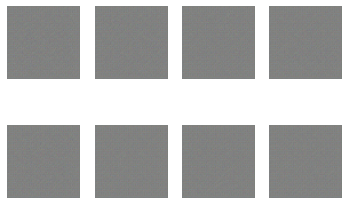

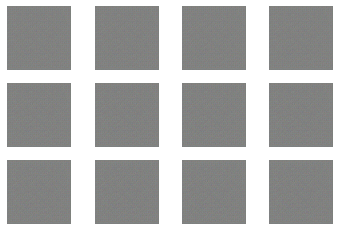

In [60]:
plot_images(netG_dcgan)

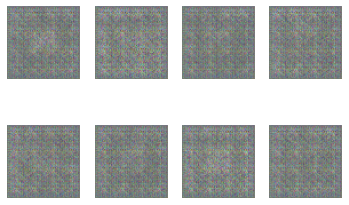

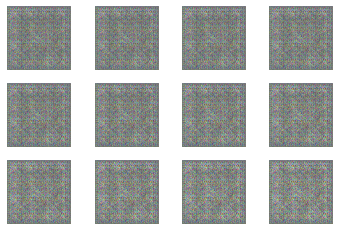

In [61]:
plot_images(netG_wgan)

In [41]:
# clear memory
del pokemon_data, netG_dcgan, netG_wgan, netD_dcgan, netD_wgan

### Train DCGAN and WGAN on Anime Dataset

In [32]:
img_list = []
data_path = 'anime-dataset'

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.png'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
anime_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

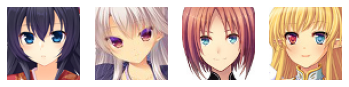

In [33]:
for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

In [42]:
# define GANs
netG_dcgan, netD_dcgan = define_gan()
netG_wgan, netD_wgan = define_gan()

In [43]:
# train DCGAN
netG_dcgan, netD_dcgan = train_dcgan(netG_dcgan, netD_dcgan, anime_data, epochs)

speed: 89.73554776583319 samples/s
discriminator loss = 1.853311, generator loss = 5.274588, binary training acc = 0.375000 at iter 0 epoch 0
speed: 282.257017639785 samples/s
discriminator loss = 0.034689, generator loss = 9.960998, binary training acc = 0.954350 at iter 50 epoch 0
speed: 296.87816552642465 samples/s
discriminator loss = 0.469297, generator loss = 12.693551, binary training acc = 0.886757 at iter 100 epoch 0
speed: 273.2634750776723 samples/s
discriminator loss = 0.670578, generator loss = 6.240654, binary training acc = 0.881105 at iter 150 epoch 0
speed: 281.7220303976122 samples/s
discriminator loss = 0.316293, generator loss = 5.887502, binary training acc = 0.885883 at iter 200 epoch 0
speed: 294.7792917446345 samples/s
discriminator loss = 0.627650, generator loss = 5.223886, binary training acc = 0.881910 at iter 250 epoch 0
speed: 295.4417900263045 samples/s
discriminator loss = 0.415500, generator loss = 7.957601, binary training acc = 0.877647 at iter 300 ep

In [44]:
# train WGAN
netG_wgan, netD_wgan = train_wgan(netG_wgan, netD_wgan, anime_data, epochs)

speed: 55.26945571718295 samples/s
discriminator loss = -354.438751, generator loss = 182.929443, binary training acc = 0.000000 at iter 0 epoch 0
speed: 92.77939048811966 samples/s
discriminator loss = -1949.697998, generator loss = 972.164795, binary training acc = 0.000000 at iter 50 epoch 0
speed: 94.75889306296963 samples/s
discriminator loss = -1955.522461, generator loss = 975.412537, binary training acc = 0.000000 at iter 100 epoch 0
speed: 91.99617532895256 samples/s
discriminator loss = -1954.876831, generator loss = 976.137024, binary training acc = 0.000000 at iter 150 epoch 0
speed: 93.09329809849801 samples/s
discriminator loss = -1956.454346, generator loss = 976.003357, binary training acc = 0.000000 at iter 200 epoch 0
speed: 92.10362279009667 samples/s
discriminator loss = -1955.038940, generator loss = 976.124390, binary training acc = 0.000000 at iter 250 epoch 0
speed: 92.00216608378905 samples/s
discriminator loss = -1955.336182, generator loss = 976.393860, binar

#### Plot Results

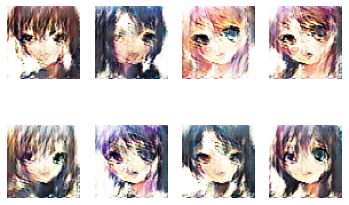

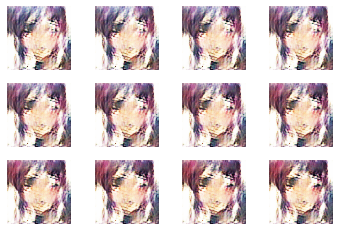

In [45]:
plot_images(netG_dcgan)

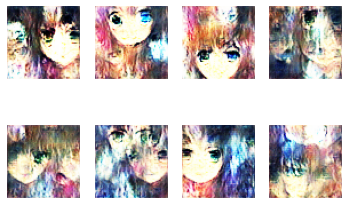

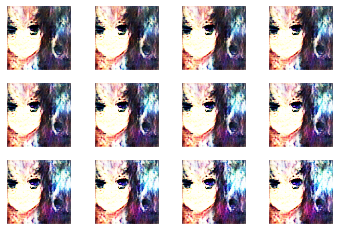

In [46]:
plot_images(netG_wgan)

In [47]:
# clear memory
del anime_data, netG_dcgan, netG_wgan, netD_dcgan, netD_wgan

### Train DCGAN and WGAN on Dogs Dataset

In [34]:
img_list = []
data_path = 'dogs-dataset'

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
dogs_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

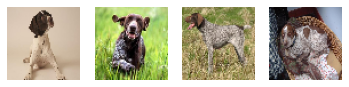

In [35]:
for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

In [48]:
# define GANs
netG_dcgan, netD_dcgan = define_gan()
netG_wgan, netD_wgan = define_gan()

In [49]:
# train DCGAN
netG_dcgan, netD_dcgan = train_dcgan(netG_dcgan, netD_dcgan, dogs_data, epochs)

speed: 91.07410362891187 samples/s
discriminator loss = 1.571243, generator loss = 3.932483, binary training acc = 0.531250 at iter 0 epoch 0
speed: 289.0617459435478 samples/s
discriminator loss = 0.486749, generator loss = 18.941282, binary training acc = 0.795650 at iter 50 epoch 0
speed: 325.31321925444763 samples/s
discriminator loss = 0.928161, generator loss = 29.167408, binary training acc = 0.816522 at iter 100 epoch 0
speed: 276.68909160250263 samples/s
discriminator loss = 0.712414, generator loss = 3.393514, binary training acc = 0.834023 at iter 150 epoch 0
speed: 305.2678542185993 samples/s
discriminator loss = 0.701741, generator loss = 5.786356, binary training acc = 0.838853 at iter 200 epoch 0
speed: 300.4475405505836 samples/s
discriminator loss = 0.409502, generator loss = 3.838696, binary training acc = 0.839828 at iter 250 epoch 0
speed: 297.8056442469197 samples/s
discriminator loss = 0.579344, generator loss = 6.941730, binary training acc = 0.851381 at iter 300

In [50]:
# train WGAN
netG_wgan, netD_wgan = train_wgan(netG_wgan, netD_wgan, dogs_data, epochs)

speed: 54.60084729973045 samples/s
discriminator loss = -333.822510, generator loss = 205.574158, binary training acc = 0.000000 at iter 0 epoch 0
speed: 92.47173370555983 samples/s
discriminator loss = -1921.033447, generator loss = 960.618530, binary training acc = 0.000000 at iter 50 epoch 0
speed: 91.98381792076867 samples/s
discriminator loss = -1926.441162, generator loss = 963.182312, binary training acc = 0.000000 at iter 100 epoch 0
speed: 92.3876492238604 samples/s
discriminator loss = -1926.932861, generator loss = 963.461670, binary training acc = 0.000000 at iter 150 epoch 0
speed: 93.65637117634869 samples/s
discriminator loss = -1927.307495, generator loss = 963.724060, binary training acc = 0.000000 at iter 200 epoch 0
speed: 94.80581361180805 samples/s
discriminator loss = -1928.046021, generator loss = 964.065002, binary training acc = 0.000000 at iter 250 epoch 0
speed: 93.86839738434101 samples/s
discriminator loss = -1927.150391, generator loss = 963.545898, binary

#### Plot Results

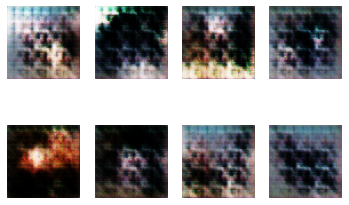

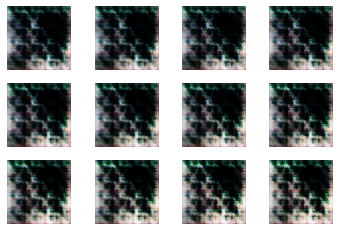

In [51]:
plot_images(netG_dcgan)

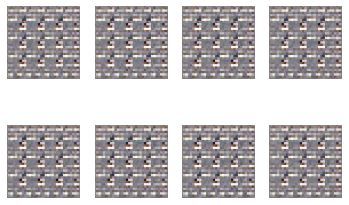

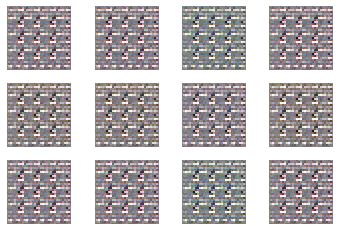

In [52]:
plot_images(netG_wgan)

In [54]:
# clear memory
del dogs_data, netG_dcgan, netG_wgan, netD_dcgan, netD_wgan